# Slicer Dashboard Stats

This notebook allows to collect statistics associated with the configuration, building, testing and distrbution of Slicer extensions on the official build machine.

See [What is an extension ?](https://www.slicer.org/slicerWiki/index.php/Documentation/Nightly/SlicerApplication/ExtensionsManager#What_is_an_extension_.3F)

The official build machine are also know as *factories*. Characteristics of each machine are documented [here](https://www.slicer.org/slicerWiki/index.php/Documentation/Nightly/Developers/Factory).

The Slicer extensions are built on a daily basis on Linux, MacOSX and Windows. The visualizations reported below are intented to help understanding which extensions are not available and why.

Currently, the visualizations are explicitly rendered for a **given date**.

In [1]:
date = "2016-04-29"
sites = ['factory-south-ubuntu', 'factory-south-w', 'factory']
group = "Extensions-Nightly"

url = "slicer.cdash.org"
project = "Slicer4"

Ultimately, this notebook will be improved to gather data over time and should allow us to understand how build parameters affect the performance of the build infrastucture. For practical reasons, some of the code may also be refactored into dedicated components reusable outside of this notebook.

## List of visualizations

 * [table: Compact list of failed extensions per platform](#table_failed_extensions) 
 * [plot: Bar chart of 'configure+build+test' times by site by extension](#plot_1)
 * [plot: Gantt chart of |configure, build, test| times by extension (ordered by start times)](#plot_2)


## Download, transform and render

* [Todos](#Todos)
* [Prerequisites](#Prerequisites)
* Download
  * [Retrieve expected extensions names](#Retrieve-expected-extensions-names)
  * [Download data from CDash](#Download-data-from-CDash)
  * [Check extension packages availability](#Check-extension-packages-availability)
* [Transform data](#Transform-data)
* Render
  * [Summary of failed extensions](#Summary-of-failed-extensions)
  * [Display cumulative times for all extensions](#Display-cumulative-times-for-all-extensions)
  * [Visualize extension times and errors](#Visualize-extension-times-and-errors)
  * [Gantt chart of extension times](#Gantt-chart-of-extension-times)

## Todos

* <del>Retrieve list of expected extensions checking out the Extensions index</del>
* <del>Initialize `sites_df` using list of expected extensions</del>
* Retrieve list of extensions packages effectively uploaded in the extensions manager

### Prerequisites

In [2]:
! pip install arrow

### Retrieve expected extensions names

In [3]:
%%bash
mkdir -p ./tmp
cd ./tmp
if [[ ! -e ExtensionsIndex ]]; then
  git clone -q git://github.com/Slicer/ExtensionsIndex
fi
cd ExtensionsIndex && \
git fetch -q origin && \
git reset -q --hard origin/master && \
(ls -1 *.s4ext | cut -d"." -f1 > ../ExpectedExtensionsNames.txt) && \
echo "Generated ./tmp/ExpectedExtensionsNames.txt"

Generated ./tmp/ExpectedExtensionsNames.txt


In [4]:
with open('./tmp/ExpectedExtensionsNames.txt') as file:
    expected_extensions = file.read().splitlines() 
    
# Account for testing extension directly checked in Slicer source tree
testing_extensions = ['CLIExtensionTemplate', 'LoadableExtensionTemplate', 'ScriptedLoadableExtensionTemplate', 'SuperBuildExtensionTemplate']
expected_extensions.extend(testing_extensions)
    
print("There are %d expected extensions" % len(expected_extensions))

There are 96 expected extensions


### Download data from CDash

Using `cdashapi.Downloader`, we can selectively download data. This is equivalent to the filter UI available from the CDash web page.


In [5]:
from cdashapi import Downloader

sites_data = {}

for site in sites:
    print("Downloading '%s' site data..." % site)
    sites_data[site] = (
        Downloader(url, project, date=date).debug(False).
        site(site).
        groupname(group)()
    )

### Check extension packages availability

TODO

### Transform data


In [6]:
import arrow
import numpy as np
import pandas as pd

from cdashapi import Transformer

# Create dataframe with 
#  
#  * a hierarchical index of the form: <sites> ( <names> )
#
#  * data columns

sites_data_columns = ['start_times']

timedelta_columns = ['configure_times', 'build_times', 'test_times']
sites_data_columns.extend(timedelta_columns)

error_columns = ['configure_errors', 'build_errors']
sites_data_columns.extend(error_columns)

data_columns = list(sites_data_columns)

sites_df = None

for site, submission_data in sites_data.items():
    
    site_data = (Transformer(submission_data).
                 labels().
                 start_times(update=lambda value:pd.Timestamp(arrow.get(value).datetime)).
                 configure_times().build_times().test_times().
                 configure_errors().build_errors().transformed_data())
    
    # Keys for each level of indexing
    sites_index = [site]
    names_index = site_data['labels']
    
    # Explicit building of the index and association of names with each levels
    index = pd.MultiIndex.from_product([sites_index, names_index],
                                       names=['sites', 'names'])
    
    # Convert column based representation into list of tuples
    data_tuples = list(zip(*(site_data[key] for key in sites_data_columns)))
    
    # Create site dataframe with (1) list of data tuples and (2) hierarchical index
    site_df = (pd.DataFrame(data_tuples, index=index, columns=sites_data_columns))
    
    # Compute errors <= configure_errors + build_errors
    site_df['errors'] = site_df[error_columns].sum(axis=1).astype(np.int)
    if 'errors' not in data_columns: data_columns.append('errors')
    
    print(" site_df: [%d rows x %d columns][%s]" % (*site_df.shape, site))
    
    if sites_df is None:
        sites_df = site_df
    else:
        sites_df = sites_df.merge(site_df, left_index=True, right_index=True, how='outer', on=data_columns)

print("sites_df: [%d rows x %d columns]\n" % (sites_df.shape))


# Keep track of expected extensions not submitted on the dashboard
sites_nobuild_extensions = {}

expected_index = pd.DataFrame(expected_extensions)
for site in sites:
    found = expected_index.isin(sites_df.xs((site), level=('sites')).index.get_level_values('names'))
    missing = expected_index[found==False].dropna()[0].tolist()
    # Keep track of the values
    sites_nobuild_extensions[site] = missing

# Update the index to consider the full list of extensions
print("sites_df: Re-indexing to account for list of expected extensions")
sites_df = sites_df.reindex(pd.MultiIndex.from_product([sites, expected_extensions],
                                                       names=['sites', 'names']))
print("sites_df: [%d rows x %d columns]\n" % (sites_df.shape))

# Add 'nobuild' column
print("sites_df: Adding 'nobuild' column")
sites_df['nobuild'] = pd.Series(np.zeros(sites_df.shape[0], dtype=bool), index=sites_df.index)

# Sort - This avoid 'MultiIndex Slicing requires the index to be fully lexsorted tuple len (2), lexsort depth (0)'
sites_df = sites_df.sortlevel()

# Update 'nobuild' column
idx = pd.IndexSlice
for site in sites:
    sites_df.loc[idx[site, sites_nobuild_extensions[site]], ['nobuild']] = True
print("sites_df: [%d rows x %d columns]\n" % (sites_df.shape))

 site_df: [95 rows x 7 columns][factory]
 site_df: [89 rows x 7 columns][factory-south-ubuntu]
 site_df: [87 rows x 7 columns][factory-south-w]
sites_df: [271 rows x 7 columns]

sites_df: Re-indexing to account for list of expected extensions
sites_df: [288 rows x 7 columns]

sites_df: Adding 'nobuild' column
sites_df: [288 rows x 8 columns]



### Helper function: Output &lt;a id='an_id'&gt;

In [7]:
from IPython.display import display, HTML 
def section(_id):
    #print("Adding <a id='%s'></a>" % _id)
    display(HTML("<a id='%s'></a>" % _id))

### Summary of failed extensions

An extension is considered to be **failed** if it is **NOT** available in the [extension manager](https://www.slicer.org/slicerWiki/index.php/Documentation/Nightly/SlicerApplication/ExtensionsManager#Extensions_Manager):
* `nobuild`: build never had a chance to start on the build machine.
* `errors`: build started but failed because of configure or build errors.
* `nopackage`: extension package is not available.


In [8]:
missing = sites_df.loc[idx[:,:], ['nobuild', 'errors', *timedelta_columns]]
missing = missing[(missing['nobuild'] == True) | (missing['errors'] > 0)]
missing['times'] = missing.loc[idx[:,:], timedelta_columns].sum(axis=1) / np.timedelta64(1, 'm')
missing = missing.drop(timedelta_columns, axis=1)
#missing = missing.drop(['times'], axis=1) # Comment/Uncomment to add/remove 'times' column
missing = missing.unstack('sites')
missing.columns = missing.columns.swaplevel(0, 1)
missing.sortlevel(0, axis=1, inplace=True)
missing.fillna(False, inplace=True) # Didn't find a way to selectively fill column with multiindex 

def mark_if_failed_or_valid(row):
    nobuild = row[0] == True
    errors = row[1] > 0
    valid = not nobuild and not errors
    css='background-color: %s'
    return [css % 'lightgreen' if valid else css % 'lightpink' for cell in row]

section('table_failed_extensions')

# case insensitive sort
missing = missing.reindex(sorted(missing.index, key=lambda x: x.lower()))

styled = missing.style
for site in sites:
    styled = styled.apply(mark_if_failed_or_valid, 'columns', subset=idx[:, idx[site, :]])

styled

### Display cumulative times for all extensions

In [9]:
cumul_times = sites_df.loc[idx[:,:], timedelta_columns]
cumul_times['overall_times'] = cumul_times.sum(axis=1)
cumul_times.sum(level='sites')

,configure_times,build_times,test_times,overall_times
sites,,,,
factory,00:09:47,03:55:24,00:42:39,04:47:50
factory-south-ubuntu,00:07:07,06:55:41,00:13:51,07:16:39
factory-south-w,00:32:02,06:01:48,00:43:51,07:17:41


### Helper functions

In [10]:
import pandas as pd
def merge(_dfs, **kwargs):
    dfs = list(_dfs) # Copy
    #print(dfs)
    merged = None
    if len(dfs) > 0:
        merged = dfs.pop(0)
    while len(dfs) > 0:
        merged = pd.merge(merged, dfs.pop(0), **kwargs)
    return merged

In [11]:
def ticklabels_mark_failed_extensions(ticklabels, site=None, fontsize=14, position=(0.05, 0.95)):
    # mark extension that failed

    for ticklabel in ticklabels:
        extension_name = ticklabel.get_text()
        
        if sites_df.loc[idx[[site] if site else slice(None), [extension_name]], ['nobuild']].sum()[0] > 0:
            ticklabel.set_color('red')
        
        elif sites_df.loc[idx[[site] if site else slice(None), [extension_name]], ['errors']].sum()[0] > 0:
            ticklabel.set_color('orange')
    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    with_build_error_extra_txt = " on at least one site" if site is None else ""
    no_build_extra_txt   = "for at least one site" if site is None else ""
        
    # place a text box in upper left in axes coords
    txt = ax.text(*position,
                  "Extension name mapping:\n"
                  " * Orange: Configure or build errors %s\n"
                  " * Red: No build found %s"% (with_build_error_extra_txt, no_build_extra_txt),
                  transform=ax.transAxes, fontsize=fontsize,
                  verticalalignment='top', bbox=props)

### Visualize extension times and errors

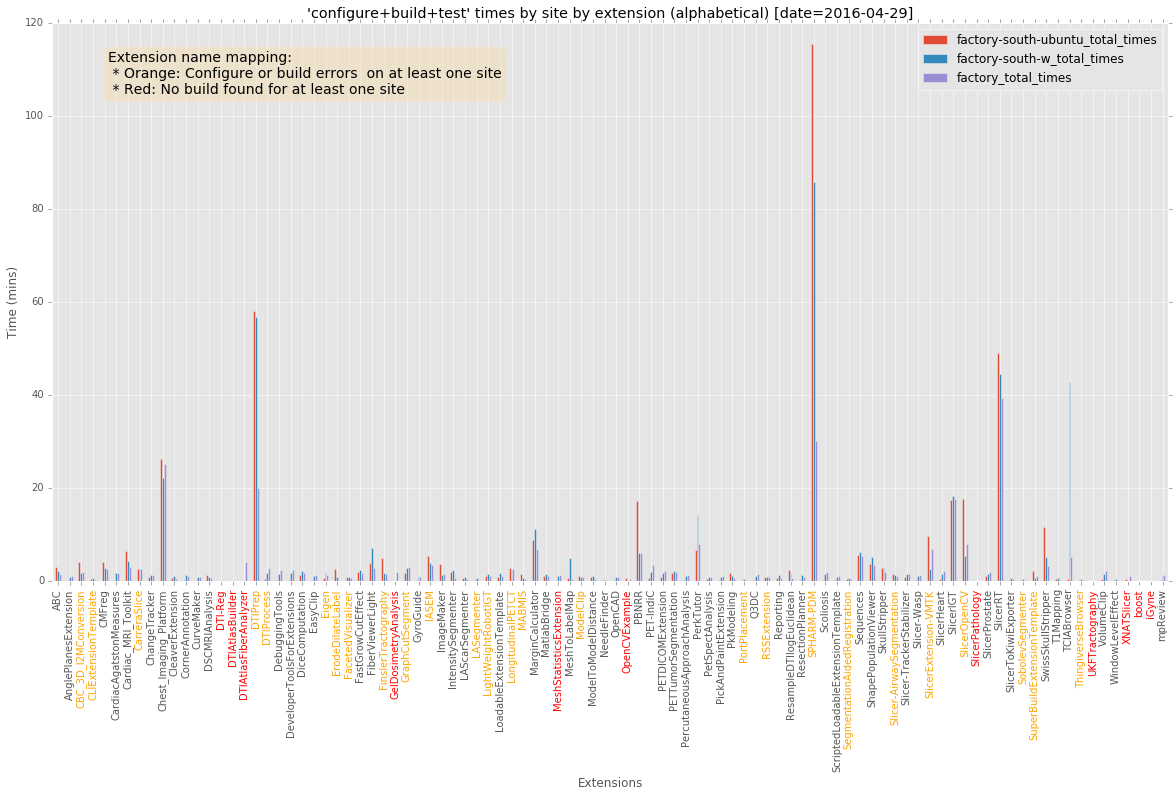

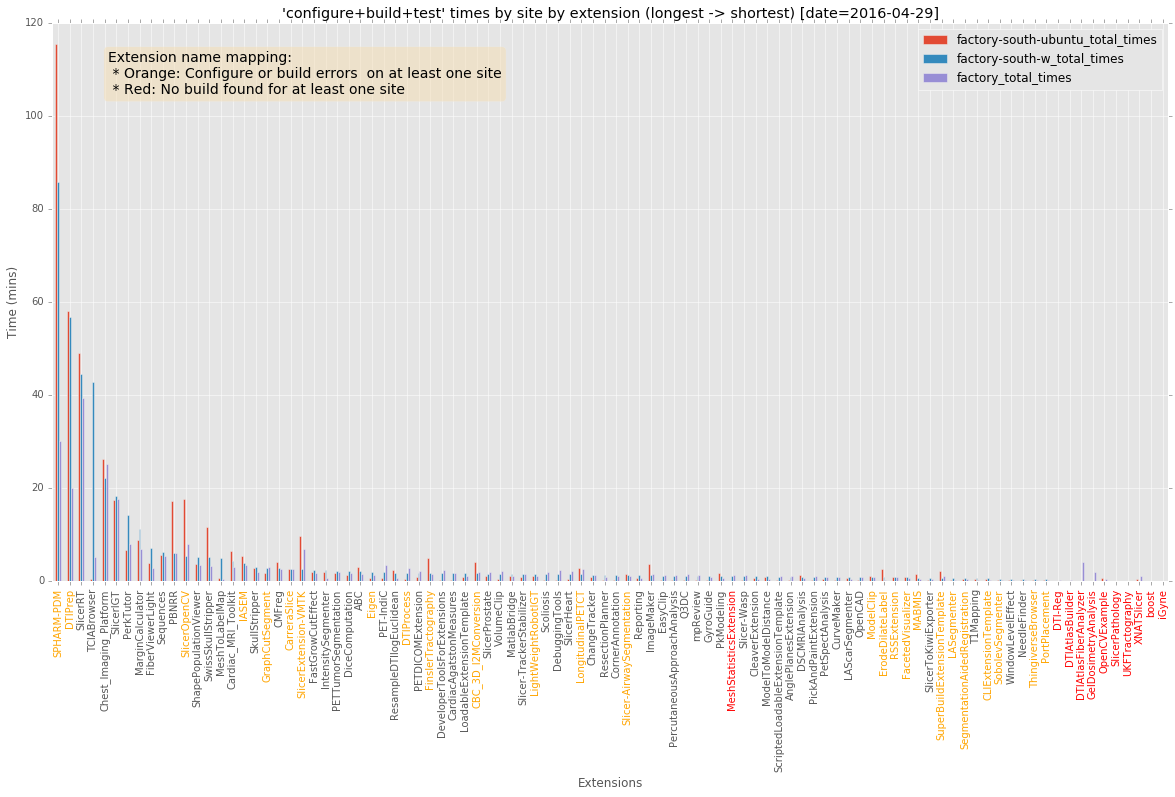

In [12]:
%matplotlib inline

section('plot_1')

import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')

figsize = (20, 10)
sharex = False

#fig, axes = plt.subplots(2, sharex=sharex)
fig = plt.figure()
axes = [plt.gca()]

axes_index = iter(range(len(axes)))

# subplot
title = "'configure+build+test' times by site by extension (alphabetical) [date=%s]" % date

time_plot_df = merge(
    [(sites_df.xs((site), level=('sites'))                       # for each site
      [timedelta_columns].sum(axis=1) / np.timedelta64(1, 'm')). # compute total_times <= configure+build+test
     to_frame('%s_total_times' % site)                           # convert from time series and rename
     for site in sites],
    left_index=True, right_index=True                            # finally, merge
).sortlevel(level='names')                                       # and sort

ax = time_plot_df.plot.bar(ax=axes[next(axes_index)], figsize=figsize, title=title, use_index=True)
ax.set_xlabel("Extensions")
ax.set_ylabel("Time (mins)")
ticklabels_mark_failed_extensions(ax.get_xticklabels())

# subplot
title = "'configure+build' errors by site by extension (alphabetical) [date=%s]" % date

error_plot_df = merge(
    [(sites_df.xs((site), level=('sites'))                       # for each site
      ['errors']). # compute total_times <= configure+build+test
     to_frame('%s_errors' % site)                                # convert from time series and rename
     for site in sites],
    left_index=True, right_index=True                            # finally, merge
).sortlevel(level='names')                                       # and sort

# ax = error_plot_df.plot.bar(ax=axes[next(axes_index)], figsize=figsize, title=title, use_index=True)
# ax.set_xlabel("Extensions")
# ax.set_ylabel("'configure+build' errors")
# ticklabels_mark_failed_extensions(ax.get_xticklabels())

#plt.tight_layout()

#-------------------------------------------------------------------------------

# fig, axes = plt.subplots(2, sharex=sharex)
fig = plt.figure()
axes = [plt.gca()]

axes_index = iter(range(len(axes)))

# subplot
title = "'configure+build+test' times by site by extension (longest -> shortest) [date=%s]" % date

time_plot_df = time_plot_df.sort_values(by='factory-south-w_total_times', ascending=False)

ax = time_plot_df.plot.bar(ax=axes[next(axes_index)], figsize=figsize, title=title, use_index=True)
ax.set_xlabel("Extensions")
ax.set_ylabel("Time (mins)")
ticklabels_mark_failed_extensions(ax.get_xticklabels())

# # subplot
# title = "'configure+build+test' errors by site by extension (sorted by times longest -> shortest) [date=%s]" % date

# error_plot_df = error_plot_df.reindex_axis(time_plot_df.index.get_level_values('names'))

# ax = error_plot_df.plot.bar(ax=axes[next(axes_index)], figsize=figsize, title=title, use_index=True)
# ax.set_xlabel("Extensions")
# ax.set_ylabel("'configure+build' errors")
# ticklabels_mark_failed_extensions(ax.get_xticklabels())

# plt.tight_layout()

#-------------------------------------------------------------------------------

# fig = plt.figure()
# figsize = (10, 10)

# number=15
# title = "'configure+build+test' times by site by extension (longest -> shortest) [N=%d, date=%s]" % (number, date)

# time_plot_df = time_plot_df.head(number)

# ax = time_plot_df.plot.bar(figsize=figsize, title=title, use_index=True)
# ax.set_xlabel("Extensions")
# ax.set_ylabel("Time (mins)")
# ticklabels_mark_failed_extensions(ax.get_xticklabels())

# plt.tight_layout();

### Gantt chart of extension times

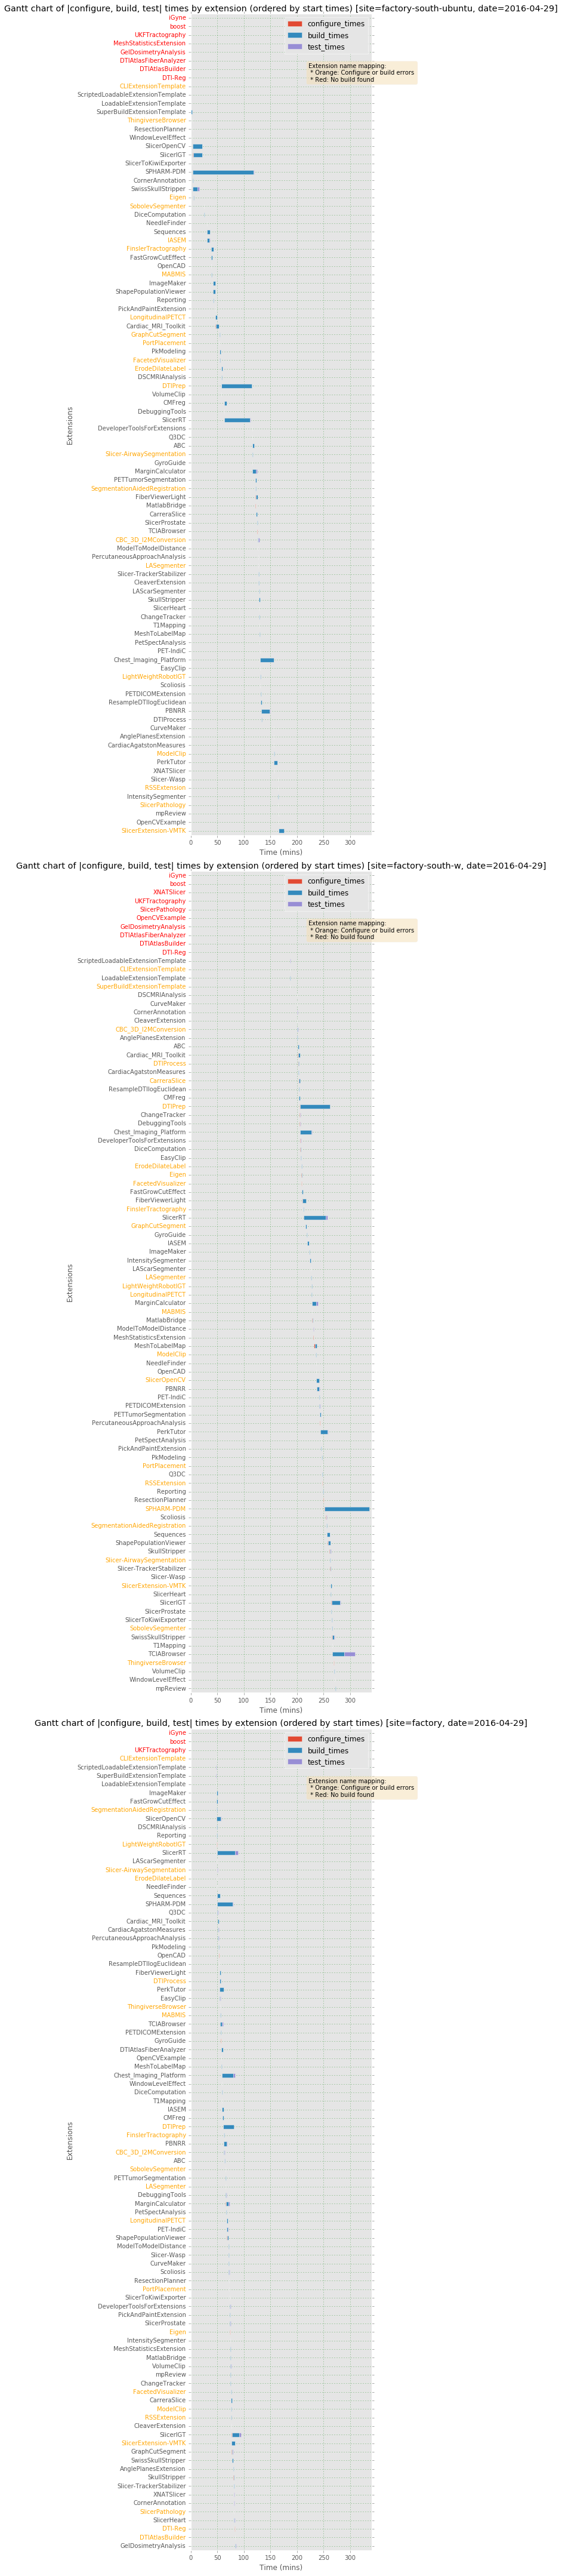

In [13]:

section('plot_2')

figsize = (10, 60)

fig, axes = plt.subplots(len(sites), sharex=False)
axes_index = iter(range(len(axes)))

reference_time = None
overall_xmin = 0
overall_xmax = 0

for site in sites:

    title = "Gantt chart of |configure, build, test| times by extension (ordered by start times) [site=%s, date=%s]" % (site, date)

    # select rows matching 'site'
    sites_sorted_df = sites_df.xs((site), level=('sites')).sort_values(by='start_times', ascending=False)

    # select all 'times' columns and convert to floats
    time_plot_df = (((sites_sorted_df[timedelta_columns]).
                     apply(lambda td: td / np.timedelta64(1, 'm'))) # convert timedeltas to floats
                   )

    # select 'start_times'
    start_times = sites_sorted_df['start_times']
    
    # set reference time if needed
    if reference_time is None:
        reference_time = start_times.min()
    
    # compute offset
    offset = reference_time - start_times.min()
    
    # compute relative location of each configure+build+test
    barh_x = ((start_times - start_times.min()) - offset) / np.timedelta64(1, 'm')

    ax = time_plot_df.plot.barh(
        ax=axes[next(axes_index)],
        figsize=figsize, 
        title=title,
        use_index=True,
        stacked=True,
        left=barh_x)
    ax.set_xlabel("Time (mins)")
    ax.set_ylabel("Extensions")
    ax.grid(color = 'g', linestyle = ':')
    
    # Keep track of the smallest/largest limit accross all sites
    if ax.get_xlim()[0] < overall_xmin:
        overall_xmin = ax.get_xlim()[0]
    if ax.get_xlim()[1] > overall_xmax:
        overall_xmax = ax.get_xlim()[1]
    
    # mark extension that failed
    ticklabels_mark_failed_extensions(ax.get_yticklabels(), site, fontsize=10, position=(0.65, 0.94))

# Update x limites
for site in sites:
    axes[sites.index(site)].set_xlim([overall_xmin, overall_xmax])

plt.tight_layout();